# News Mood with Tweepy and vaderSentiment
Sentiment analysis of Twitter news sources using Python. Use the following outlets: BBC, CBS, CNN, Fox, New York Times.

## Dependencies and Setup

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tweepy
import time

# Ignore deprecated function warnings
import warnings
warnings.filterwarnings("ignore")

# Change this to whichever file contains your keys
from myconfig import consumer_key, consumer_secret, access_token, access_token_secret

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [174]:
# tweepy API authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# vader analyzer
analyzer = SentimentIntensityAnalyzer()

## Get data

In [175]:
# Get data for these news sources
sources = ["FoxNews", "CNN", "BBCWorld", "CBSNews", "nytimes"]

# Store data using dictionary to create dataframe easily later
tweet_data = {
    "tweet_source": [],
    "tweet_text": [],
    "tweet_date": [],
    "tweet_vader_score": [],
    "tweet_pos_score": [],
    "tweet_neu_score": [],
    "tweet_neg_score": [],
}

# Pagination
for x in range(5):
    for source in sources:
        # data for tweets
        public_tweets = api.user_timeline(source, page=x)
        for tweet in public_tweets:
            # get data for tweeter, the tweet itself, and the tweet's creation date
            tweet_data["tweet_source"].append(tweet["user"]["name"])
            tweet_data["tweet_text"].append(tweet["text"])
            tweet_data["tweet_date"].append(tweet["created_at"])

            # vader's polarity_scores
            results = analyzer.polarity_scores(tweet["text"])
            tweet_data["tweet_vader_score"].append(results["compound"])
            tweet_data["tweet_pos_score"].append(results["pos"])
            tweet_data["tweet_neu_score"].append(results["neu"])
            tweet_data["tweet_neg_score"].append(results["neg"])

## DataFrame

In [176]:
tweet_df = pd.DataFrame.from_dict(tweet_data)

# Save the file with date
file_name = str(time.strftime("%m-%d-%y")) + "_tweets.csv"
tweet_df.to_csv("analysis/" + file_name, encoding="utf-8")
tweet_df.head()

,tweet_source,tweet_text,tweet_date,tweet_vader_score,tweet_pos_score,tweet_neu_score,tweet_neg_score
0,Fox News,BREAKING: Federal appeals court rules against ...,Thu Nov 08 19:18:44 +0000 2018,0.0000,0.000,1.000,0.000
1,Fox News,Breaking News: Grand jury indicts captain of M...,Thu Nov 08 17:02:25 +0000 2018,-0.6124,0.115,0.615,0.269
2,Fox News,JUST IN: Police identify gunman who opened fir...,Thu Nov 08 15:14:45 +0000 2018,-0.7783,0.000,0.638,0.362
3,Fox News,JUST IN: Supreme Court Justice Ruth Bader Gins...,Thu Nov 08 14:22:51 +0000 2018,0.7906,0.389,0.611,0.000
4,Fox News,Sgt. Ron Helus was fatally shot when he respon...,Thu Nov 08 13:43:25 +0000 2018,-0.6369,0.000,0.833,0.167


In [177]:
# Convert string dates into datetime objects
tweet_df.dtypes

tweet_source          object
tweet_text            object
tweet_date            object
tweet_vader_score    float64
tweet_pos_score      float64
tweet_neu_score      float64
tweet_neg_score      float64
dtype: object

In [178]:
tweet_df["tweet_date"] = pd.to_datetime(tweet_df["tweet_date"])
# Now, we are able to sort by the date column
tweet_df.sort_values("tweet_date", inplace=True)
tweet_df.reset_index(drop=True, inplace=True)
tweet_df.head()

,tweet_source,tweet_text,tweet_date,tweet_vader_score,tweet_pos_score,tweet_neu_score,tweet_neg_score
0,Fox News,McDonald's customers’ $5M lawsuit over unwante...,2018-11-08 03:01:47+00:00,-0.4215,0.000,0.743,0.257
1,Fox News,Woman finds her diamond before proposal and 'r...,2018-11-08 03:04:00+00:00,-0.0772,0.170,0.638,0.191
2,Fox News,.@senatemajldr Mitch McConnell said Wednesday ...,2018-11-08 03:11:00+00:00,0.4939,0.158,0.842,0.000
3,Fox News,Surveillance video shows Michigan woman report...,2018-11-08 03:16:01+00:00,0.0000,0.000,1.000,0.000
4,Fox News,"Democrat Colin Allred, who unseated Rep. Pete ...",2018-11-08 03:23:00+00:00,0.0000,0.000,1.000,0.000


## Plot
Create a scatter plot to visualize the last 100 tweets of each news organization using the compound sentiment score. 

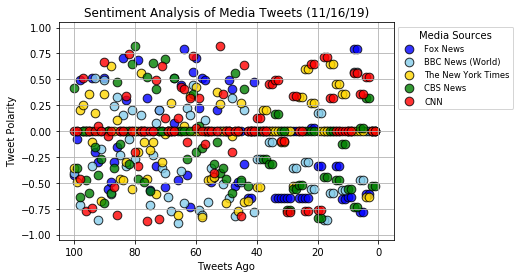

In [179]:
# Scatter plots with different colors per label, can be done with plotly as well
colors = {"Fox News": "blue", "BBC News (World)": "skyblue", 
          "The New York Times": "gold", "CBS News": "green", 
          "CNN": "red"}

fig, ax = plt.subplots()
for source in tweet_df["tweet_source"].unique():
    ax.scatter(np.arange(-len(tweet_df[tweet_df["tweet_source"] == source]), 0, 1), 
            tweet_df[tweet_df["tweet_source"] == source]["tweet_vader_score"],
            edgecolor="black", linewidths=1, marker="o", color=colors[source], s=75,
            alpha=0.8, label=source)
# extra plot properties
plt.title(f"Sentiment Analysis of Media Tweets ({time.strftime('%x')})")
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.xlim([-105, 5])
plt.xticks([-100, -80, -60, -40, -20, 0], [100, 80, 60, 40, 20, 0])
plt.ylim([-1.05, 1.05])
plt.grid()

lgnd = plt.legend(fontsize="small", mode="Expanded", 
                  loc="best", bbox_to_anchor=(1,1), title="Media Sources")

file_name = str(time.strftime("%m-%d-%y")) + "_Fig1.png"
plt.savefig("analysis/" + file_name, bbox_extra_artists=(lgnd, ), bbox_inches='tight')
plt.show()

## Summary Bar Graph
Create a summary bar graph for the news organizations for their average compound scores of their last 100 tweets. 

In [180]:
# Get the average compound scores (vader scores)
mean_compound_score = tweet_df.groupby(["tweet_source"]).mean()["tweet_vader_score"]
mean_compound_score_df = pd.DataFrame(mean_compound_score)
mean_compound_score_df.head()

,tweet_vader_score
tweet_source,
BBC News (World),-0.173338
CBS News,-0.151797
CNN,0.047303
Fox News,-0.116200
The New York Times,-0.044998


In [181]:
compound_values = mean_compound_score_df["tweet_vader_score"].tolist()
compound_values

[-0.173338,
 -0.15179700000000002,
 0.04730300000000001,
 -0.11620000000000001,
 -0.04499799999999997]

In [182]:
# Takes in one bar plot and current index x to add location of text
def autolabel(rects, x):
        for rect in rects:
            height = rect.get_height()
            if compound_values[x] > 0:
                delta_height = 0.005
                string_value = '+%.2f' % float(height)
            else: 
                # values under x-axis show neater
                delta_height = -0.010
                string_value = '-%.2f' % float(height)
            ax.text(rect.get_x() + rect.get_width() / 2., height + delta_height,
                    string_value, ha='center')

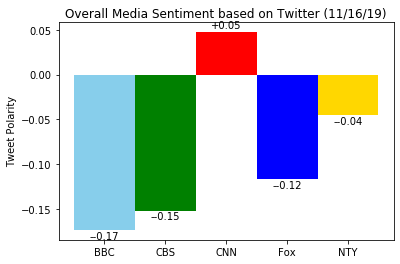

In [183]:
# Same dictionary as above
colors = {"Fox News": "blue", "BBC News (World)": "skyblue", 
          "The New York Times": "gold", "CBS News": "green", 
          "CNN": "red"}

fig, ax = plt.subplots()
# Set width to 1 and plot next to one another with first parameter (x)
width = 1
ind = np.arange(len(compound_values))  

for x in range(len(compound_values)):
    # get from dictionary
    color = colors[mean_compound_score_df.index[x]]
    rect = ax.bar(ind[x], compound_values[x], width, color=color)
    autolabel(rect, x)
    
ax.set_title(f"Overall Media Sentiment based on Twitter ({time.strftime('%x')})")
ax.set_xticks(ind)
ax.set_xticklabels(("BBC", "CBS", "CNN", "Fox", "NTY"))
ax.set_ylabel("Tweet Polarity")
ax.set_autoscaley_on(True)

file_name = str(time.strftime("%m-%d-%y")) + "_Fig2.png"
plt.savefig("analysis/" + file_name, bbox_extra_artists=(lgnd, ), bbox_inches='tight')

fig.show()